In [6]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
def get_data(timestep):
    timestep_pickle_path = f'/home/samuel-linux/PycharmProjects/Personal/FantasyBasketball/Data/combined-bbref/{timestep}.p'
    timestep_dict = pickle.load(open(timestep_pickle_path, 'rb'))
    
#     combined_train = [(player, timestep_dict[player]['x_train']) for player in timestep_dict.keys() if len(timestep_dict[player]['x_train'].shape) > 1]
#     train_player = [i[0] for i in combined_train]
#     combined_x_train = np.concatenate([i[1] for i in combined_train])
#     combined_y_train = np.concatenate([timestep_dict[player]['y_train'] for player in timestep_dict.keys() if len(timestep_dict[player]['y_train'].shape) >= 1])
    
#     combined_test = [(player, timestep_dict[player]['x_test']) for player in timestep_dict.keys() if len(timestep_dict[player]['x_test'].shape) >= 1]
#     test_player = [i[0] for i in combined_test ]
#     combined_x_test = np.concatenate([i[1] for i in combined_test])
#     combined_y_test = np.concatenate([timestep_dict[player]['y_test'] for player in timestep_dict.keys() if len(timestep_dict[player]['y_test'].shape) >= 1])
    
#     return_dict = {'timestep_dict': timestep_dict, 'x_train': combined_x_train, 'y_train': combined_y_train, 'x_test': combined_x_test, 'y_test': combined_y_test, 
#                    'train_players': train_player, 'test_players': test_players}

    combined_x_train = np.concatenate([timestep_dict[player]['x_train'] for player in timestep_dict.keys() if len(timestep_dict[player]['x_train'].shape) > 1])
    combined_x_test = np.concatenate([timestep_dict[player]['x_test'] for player in timestep_dict.keys() if len(timestep_dict[player]['x_test'].shape) > 1])
    combined_y_train = np.concatenate([timestep_dict[player]['y_train'] for player in timestep_dict.keys() if len(timestep_dict[player]['y_train'].shape) >= 1])
    combined_y_test = np.concatenate([timestep_dict[player]['y_test'] for player in timestep_dict.keys() if len(timestep_dict[player]['y_test'].shape) >= 1])
    
    return_dict = {'timestep_dict': timestep_dict, 'x_train': combined_x_train, 'y_train': combined_y_train, 'x_test': combined_x_test, 'y_test': combined_y_test}
    
    return return_dict

tts_dict = get_data(3)

In [8]:
x_train, x_test, y_train, y_test = tts_dict['x_train'], tts_dict['x_test'], tts_dict['y_train'], tts_dict['y_test']
# train_players, test_players = tts_dict['train_players'], tts_dict['test_players']
player_dict = tts_dict['timestep_dict']
print(f'X Train Shape: {x_train.shape} | Y Train Shape: {y_train.shape}')
print(f'X Test Shape: {x_test.shape}   | Y Test Shape: {y_test.shape}')

X Train Shape: (495922, 3, 19) | Y Train Shape: (495922,)
X Test Shape: (69318, 3, 19)   | Y Test Shape: (69318,)


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Conv1D, Flatten, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [46]:
def get_conv(input_shape, lr = .0001, mommentum = .5):
    
    optimizer = Adam(lr, mommentum)
    model = Sequential()
    model.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', input_shape= input_shape, padding='same'))
    model.add(Dropout(.3))
    model.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', input_shape= input_shape, padding='same'))
    model.add(Dropout(.3))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
    return model    

def plot_model_metrics(model_history, path = None, show = True):
    train_loss = model_history.history['loss']
    test_loss = model_history.history['val_loss']
    epochs = [i for i in range(1, len(train_loss) + 1)]

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(epochs, train_loss, label='Train Loss')
    ax[0].plot(epochs, test_loss, label='Test Loss')
    ax[0].set_title('Train/Test Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss (MSE)')
    ax[0].legend()
    if show == True: 
        plt.show()

    if path:
        plt.savefig(path)
    


input_shape = x_train.shape[1], x_train.shape[2]
conv_network = get_conv(input_shape)

epochs = 100
batch_size = 32
verbose = 1 

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=13, min_delta=.075)
model_checkpoint = ModelCheckpoint(f'test.h5', verbose=1, save_best_only=True,
                                   monitor='val_loss')
callbacks = [early_stopping, model_checkpoint]
history = conv_network.fit(x_train, y_train, callbacks= callbacks, validation_data=(x_test, y_test), verbose = verbose,
                                batch_size= batch_size, epochs = epochs)

plot_model_metrics(history)

Epoch 1/100
15498/15498 [==============================] - 82s 5ms/step - loss: 126.2354 - mse: 126.2354 - mae: 8.4569 - val_loss: 128.1789 - val_mse: 128.1789 - val_mae: 8.2743

Epoch 00001: val_loss improved from inf to 128.17891, saving model to test.h5
Epoch 2/100
15498/15498 [==============================] - 72s 5ms/step - loss: 117.4499 - mse: 117.4499 - mae: 8.1655 - val_loss: 123.4796 - val_mse: 123.4796 - val_mae: 8.1881

Epoch 00002: val_loss improved from 128.17891 to 123.47964, saving model to test.h5
Epoch 3/100
15498/15498 [==============================] - 73s 5ms/step - loss: 116.6766 - mse: 116.6766 - mae: 8.1393 - val_loss: 122.6128 - val_mse: 122.6128 - val_mae: 8.1819

Epoch 00003: val_loss improved from 123.47964 to 122.61284, saving model to test.h5
Epoch 4/100
15498/15498 [==============================] - 72s 5ms/step - loss: 116.4202 - mse: 116.4202 - mae: 8.1358 - val_loss: 127.4073 - val_mse: 127.4073 - val_mae: 8.3123

Epoch 00004: val_loss did not improve 

KeyboardInterrupt: 

In [47]:
conv_network.load_weights('test.h5')

Getting MSE: Jonathan Isaac | (15, 3, 19) | (15,): 100%|██████████| 2058/2058 [01:07<00:00, 30.68it/s]         


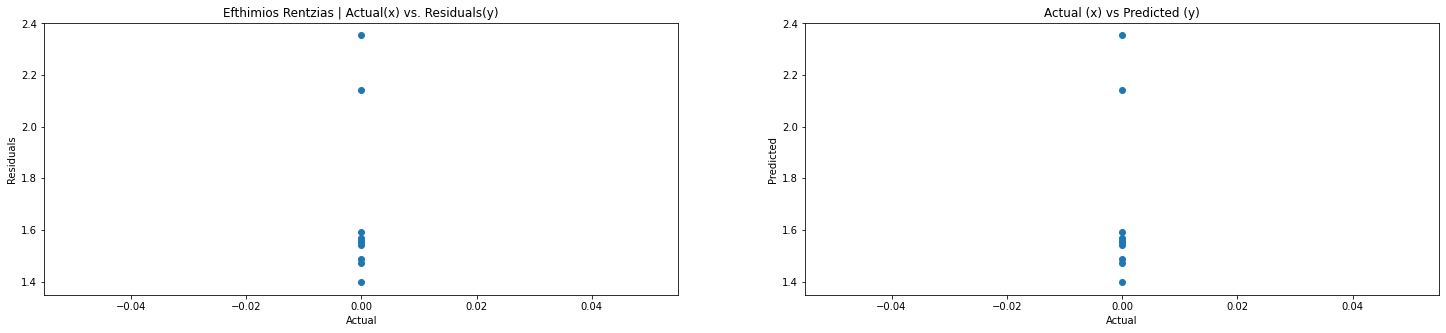

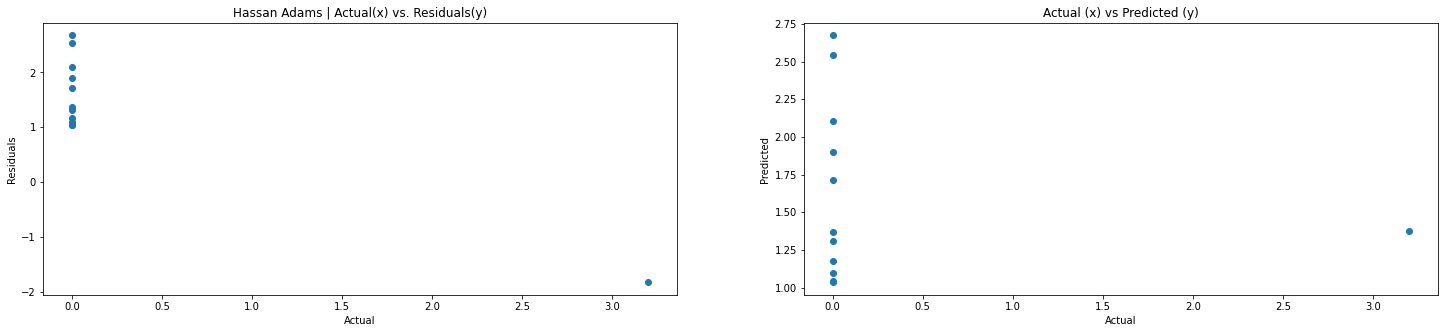

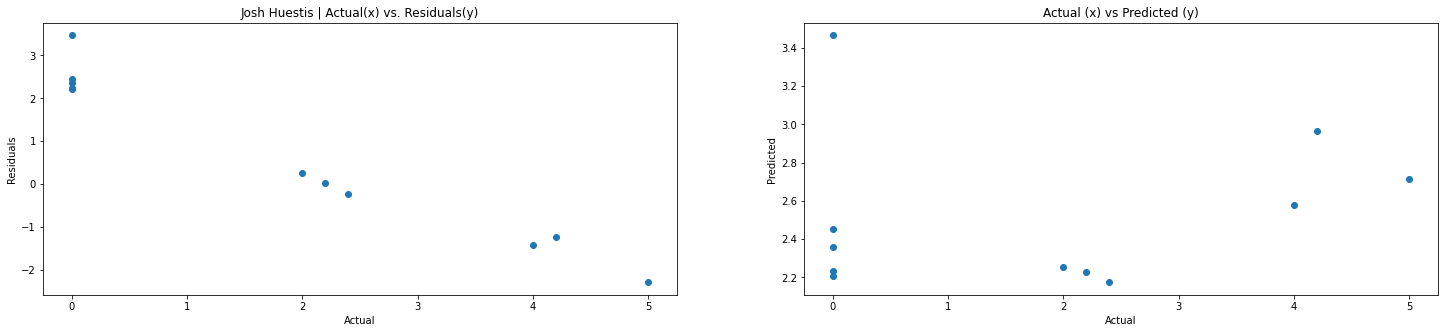

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


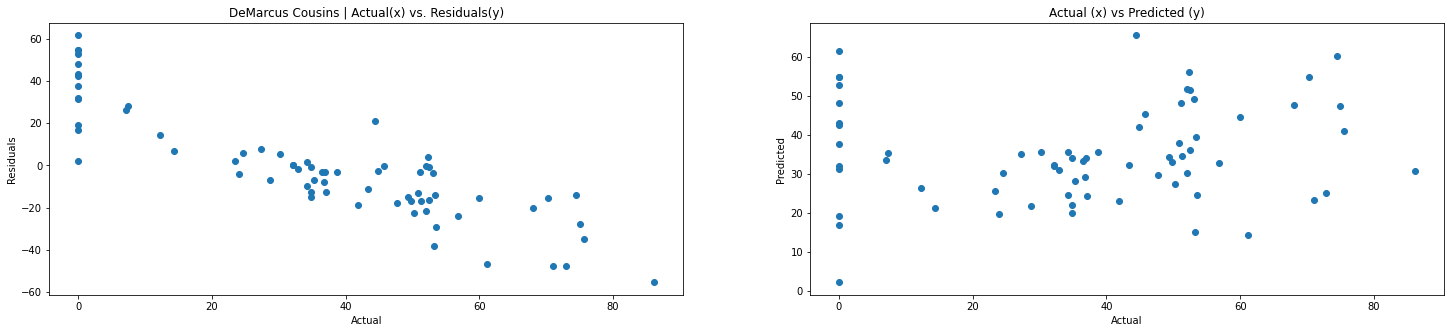

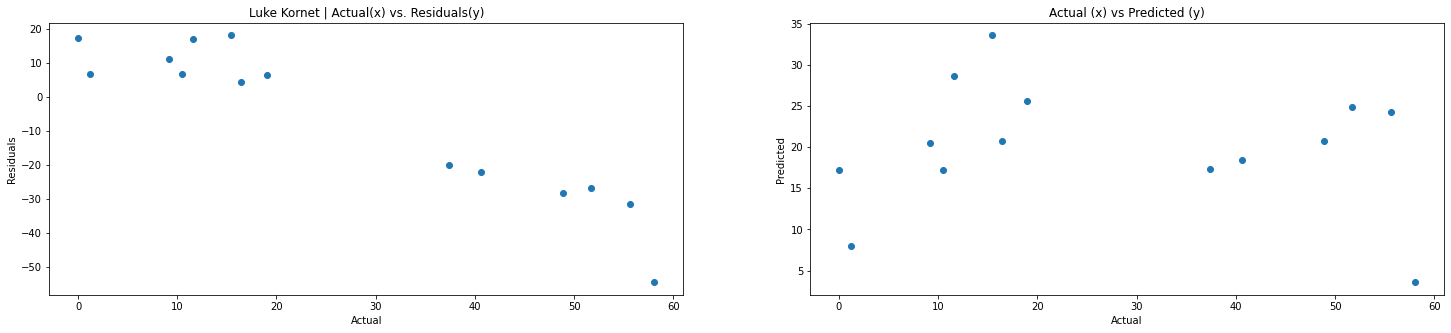

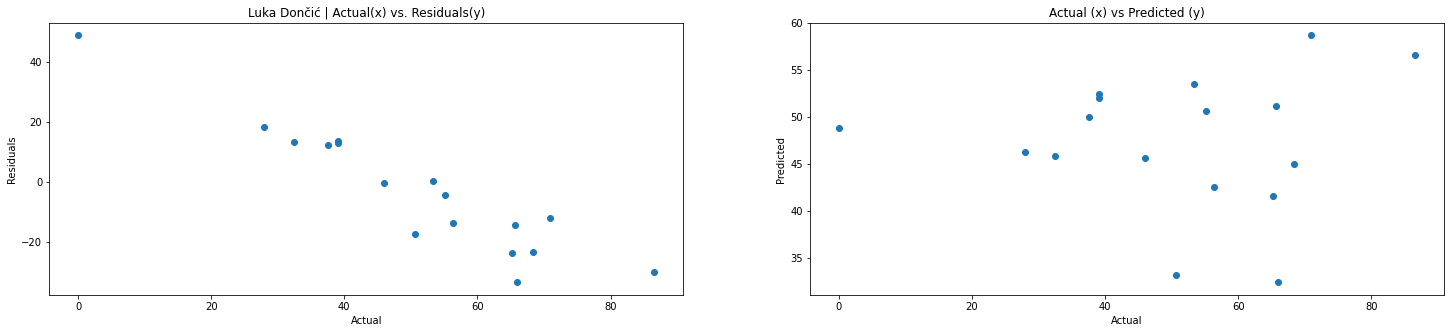

,player,loss
1377,Gerald Fitch,0.003236
84,Deni Avdija,0.066969
471,Tyrese Maxey,0.087163
205,Nicolás Laprovíttola,0.440121
992,Tyrone Corbin,0.659538
...,...,...
1267,Luke Kornet,539.664662
1739,Devon Hall,634.825503
343,DeMarcus Cousins,650.544639
309,Caleb Martin,707.822961


In [50]:
# from sklearn.metrics import mean_absolute_error as loss_calculator
from sklearn.metrics import mean_squared_error as loss_calculator

from tqdm import tqdm


def plot_res_predict(model, player_dict, players):
    count = 0
    for player in players:
#         x = np.concatenate([i for i in player_dict[player]['x_test'] if len(player_dict[player]['x_test'].shape) > 1])
#         y = np.concatenate([i for i in player_dict[player]['y_test'] if len(player_dict[player]['y_test'].shape) >= 1])
        x = player_dict[player]['x_test']
        y = player_dict[player]['y_test'] 
        if len(y) < 10: 
            continue
        y_predict = model.predict(x).ravel()
        
        residuals = y_predict - y
        
        fix, ax  = plt.subplots(1,2, figsize = (25,5))
        ax[0].scatter(y, residuals)
        ax[0].set_title(f'{player} | Actual(x) vs. Residuals(y)')
        ax[0].set_xlabel('Actual')
        ax[0].set_ylabel('Residuals')
        
        ax[1].scatter(y, y_predict)
        ax[1].set_title('Actual (x) vs Predicted (y)')
        ax[1].set_xlabel('Actual')
        ax[1].set_ylabel('Predicted') 
        plt.show()
        
        count+= 1
        if count >= 3: 
            break
        
def compare_players(model, player_dict):
    loss_list = []
    players = []
    pbar = tqdm(player_dict.keys())
    for player in pbar:
        x = player_dict[player]['x_test']
        y = player_dict[player]['y_test'] 
        if len(x) == 0: 
            continue
        pbar.set_description(f'Getting MSE: {player} | {x.shape} | {y.shape}')
#         x = np.concatenate([i for i in player_dict[player]['x_test'] if len(player_dict[player]['x_test'].shape) > 1])
#         y = np.concatenate([i for i in player_dict[player]['y_test'] if len(player_dict[player]['y_test'].shape) >= 1])      
        y_predict = model.predict(x)
#         print(y_predict.shape)
#         print(y_predict)
        loss = loss_calculator(y, y_predict)
        players.append(player)
        loss_list.append(loss)
        
    pbar.close()
    
    df = pd.DataFrame({'player': players, 'loss': loss_list}, index = [i for i in range(len(players))])
    df.sort_values(by = 'loss', ascending = True, inplace = True)
    
    player_list = df.player.values
    plot_res_predict(model, player_dict, player_list)
    print('~'* 75)
    plot_res_predict(model, player_dict, player_list[::-1])
        
    return df
compare_players_df = compare_players(conv_network, player_dict)

compare_players_df.to_csv('ComparePlayerConv.csv', index = False)
compare_players_df

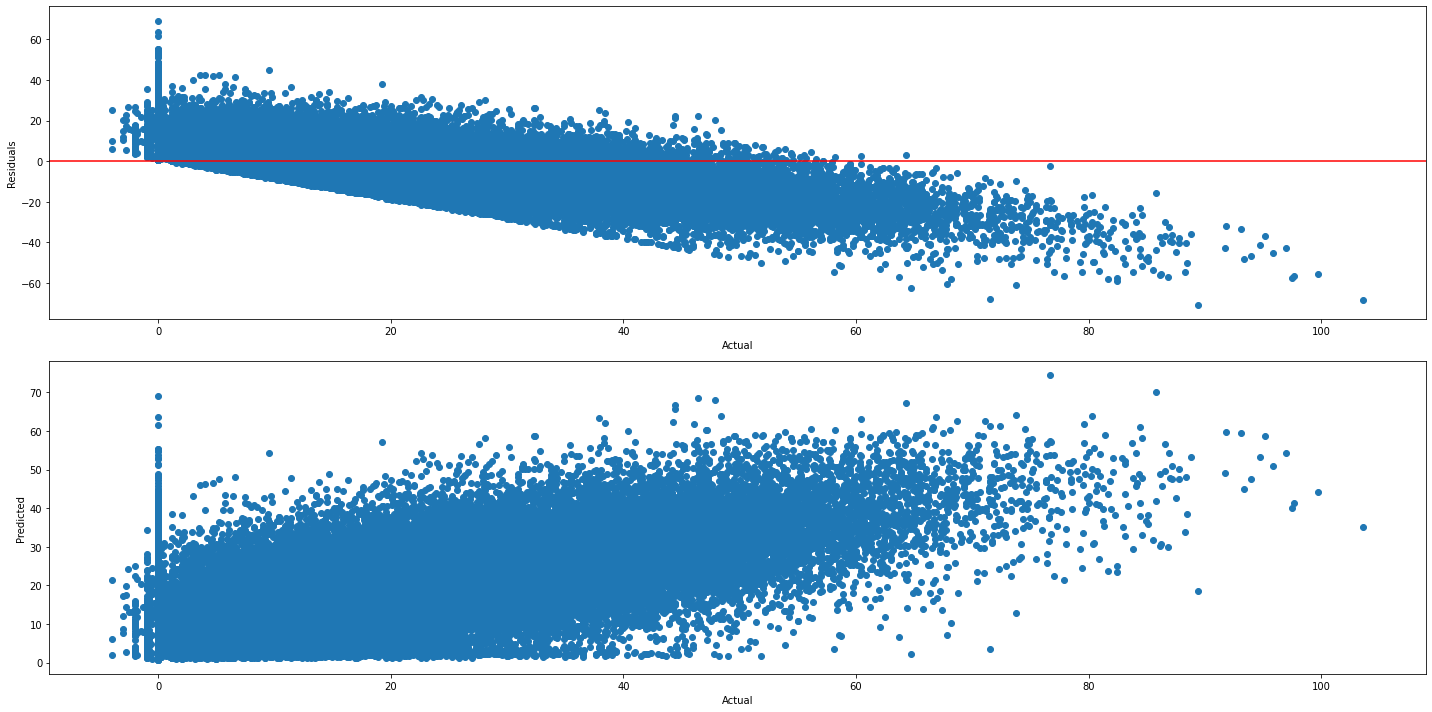

In [55]:
y_test_predict = conv_network.predict(x_test).ravel()


fig, ax = plt.subplots(2, figsize = (20, 10))
residuals = y_test_predict - y_test

ax[0].scatter(y_test, residuals)
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Residuals')
ax[0].axhline(0, color = 'red')

ax[1].scatter(y_test, y_test_predict)
ax[1].set_xlabel('Actual')
ax[1].set_ylabel('Predicted')
plt.tight_layout()
plt.show()

In [63]:
above = len([i for i in residuals if i >= 3])
below = len([i for i in residuals if i <= -3]) 
print(above, below)

24085 24065
